In [3]:
import Diagrams.Backend.Cairo.CmdLine

In [18]:
{-# LANGUAGE NoMonomorphismRestriction FlexibleContexts TypeFamilies #-}
import           Control.Monad                 (replicateM)
import           Control.Monad.Random
import           Data.Colour.Palette.ColorSet
import           Data.List                     (zipWith, zipWith3)
import           Diagrams.Prelude
import           System.Random

A helper function like `iterate` but also takes the list index as a parameter.



In [8]:
iterateIdx :: (Int -> a -> a) -> a -> [a]
iterateIdx f t = go f t 0
  where
    go f t i = let t' = f i t
               in  t' : go f t' (i + 1)


Take any Diagram and cut out an equilateral triangle of side 1 from the center.
This is the triangle inside of the three mirrors that make up a kaleidoscope.
The image is created by first repeatedly refecting this triangle and assembling
the resulting triagles into a hexagon.
Then the image plane is tiled with this hexagon.



In [19]:
kaleidoscope :: Diagram B -> Diagram B
kaleidoscope d = appends hex hexs
  where
    hexs   = zip dirs (replicate 6 hex)
    dirs   = iterate (rotateBy (1/6)) (rotateBy (1/12) unitX)
    hex    = mconcat . take 6 $ iterateIdx next tri
    tri    = alignBR $ cutTriangle d
    next i = reflectAbout (0 ^& 0) (rotateBy (- fromIntegral i / 6) xDir)

In [20]:
cutTriangle :: Diagram B -> Diagram B
cutTriangle = clipped (triangle 1) # lw none

We pass as arguments the number of pieces of confetti `n` and a random seed `r`.
Between 10 and 100 pieces seem to work nicely.



In [21]:
confettiScope :: Int -> Int -> Diagram B
confettiScope n r
  = kaleidoscope (mkConfetti n (mkStdGen r))
  # centerXY <> (circle 2.75 # fc black)
  # pad 1.1

To create an image for use in the kadeidescope we generate a bunch of disks with
random location, size, color, and opacity. This is the confetti used as the image.
Of course using circles is arbitrary, any shapes and sizes will do.



In [22]:
sizeValue :: (RandomGen g) => Rand g Double
sizeValue = getRandomR (0.05, 0.25)

In [23]:
coordValue :: (RandomGen g) => Rand g Double
coordValue = getRandomR (-0.5, 0.5)


We use monadRandom to hide the plumbing of the many random numbers we need.
The colors are choosen from the 330+ `webColors` defined in the package
`Data.Colour.Palette.ColorSet`.



In [24]:
confetti :: Int -> Rand StdGen (Diagram B)
confetti n = do
  ss <- replicateM n sizeValue   -- radius
  cs <- replicateM n getRandom   -- color index
  as <- replicateM n getRandom   -- opacity
  xs <- replicateM n coordValue  -- x coordinate
  ys <- replicateM n coordValue  -- y coordinate
  let mkCirc :: Double -> Int -> Double -> Diagram B
      mkCirc s c a = circle s # fc (webColors c) # lw none # opacity a
      pos = zipWith mkP2 xs ys
      conf = zipWith3 mkCirc ss cs as
  return $ position (zip pos conf)

Make the confetti diagram and extract it from the monad.



In [25]:
mkConfetti :: Int -> (StdGen -> Diagram B)
mkConfetti n = evalRand $ confetti n

In [27]:
example = confettiScope 39 0

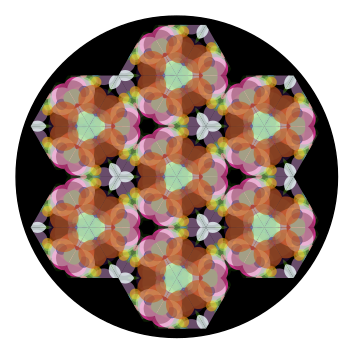

In [29]:
example